# EDA on TeX-Code

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
import random

In [2]:
file=open('final_png_formulas.txt')
for i in range(15):
    print(file.readline())

TEXT

R _ { 1 2 } K _ { 1 } R _ { 2 1 } d K _ { 2 } = d K _ { 2 } R _ { 1 2 } K _ { 1 } R _ { 1 2 } ^ { - 1 } ,

E _ { n } - E _ { m } = \frac { \lambda ^ { \prime } ( n ^ { 2 } y ^ { 2 } - m ^ { 2 } ) } { y ^ { 2 } } .

\sigma ^ { 1 } + i \sigma ^ { 2 } = f ( \sigma ^ { 1 } + i \sigma ^ { 2 } )

B | _ { \partial \Sigma _ { 3 } } \rightarrow B | _ { \partial \Sigma _ { 3 } } - \Lambda | _ { \partial \Sigma _ { 3 } } .R

\phi _ { i } ^ { \prime } ( x ) = \phi _ { i } ( x ) + \delta _ { \mathrm { B R S } } [ \phi _ { i } ] \Theta [ \phi ]

\partial _ { t } \bar { \sigma } _ { k } ^ { ( g f ) } = \frac { 1 } { \alpha } \partial _ { t } \gamma _ { k } + e \partial _ { t } \zeta _ { k } + \dots

x _ { i } = y _ { i } \left( 1 - \eta _ { 1 } \eta _ { 2 } \right) , ~ ~ \sum _ { 0 } ^ { 3 } y _ { i } ^ { 2 } = 1

\delta e ^ { s A } = \int _ { 0 } ^ { s } d t \, e ^ { t A } \delta A e ^ { ( s - t ) A } \, ,

\left( \begin{array} { c | c } { 1 } & { b ( u ) \vec { u } ^ { \mathrm { T } } } \\ \h

So none of the lines have any `$tex_code$` format, it's just the raw code. 

In [13]:
df = pd.read_table('final_png_formulas.txt')

In [11]:
def length(entry):
    return len(entry)

In [15]:
df['len']=df['TEXT'].map(length)

In [17]:
df.describe()

,len
count,238329.000000
mean,168.605142
std,112.791026
min,13.000000
25%,96.000000
50%,139.000000
75%,209.000000
max,2177.000000


So of the ~240k lines of code, the line has on average 170 characters with the smallest line of code only having 13 characters and the longest having 2177.

In [33]:
df[df['len'] > 1000]

,TEXT,len
204,\left\{ \begin{array} { r c l } { \delta _ { M...,1457
416,\begin{array} { l c l l } { \mathrm { f l o o ...,1369
958,\begin{array} { r c l } { ( i _ { \hat { k } }...,1272
2016,\begin{array} { r c l } { V _ { a } } & { = } ...,1046
2125,\begin{array} { l c l } { y _ { 6 } } & { = } ...,1229
...,...,...
235700,\begin{array} { r c l } { T _ { 1 } P _ { i } ...,1139
236007,"\begin{array} { r c l } { \chi _ { \iota , \ka...",1183
237688,\left\{ \begin{array} { r c l } { \delta { \ca...,1072
237985,\begin{array} { l l } { \{ \hat { G } _ { - \f...,1256


So one potential issue, although hopefully not, is that each line is, well, a single line. It's not really readable for a user. This could potentially be solved with postprocessing, i.e. the model will generate some code that looks something like:

`\begin{align*} x = 2// y = 5\end{align*}`

And we would just manually format the printing using some logic like 'oh put a newline character after every `\begin{..}`, `\\`, `\end{..}` etc.

Another thing is that we are just faithfully assuming each line of code will *actually compile*. That's kind of a dangerous assumption.

Let's check if we have some attributes common to tex code

In [78]:
df[df['TEXT'].str.contains('\\\\begin{equation}')]

,TEXT,len


In [77]:
df[df['TEXT'].str.contains('\\\\begin{align}')]

,TEXT,len


OK, so no entries have the formatting for align or equation environments. We will definitely want this for generating the code, so we will likely have to append and prepend these to some samples in the dataset before training. 

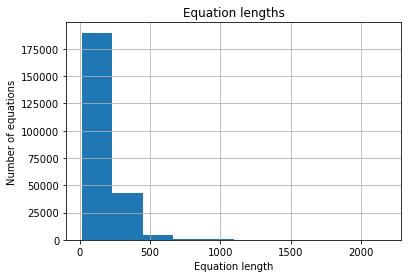

In [81]:
df['len'].hist()
plt.title('Equation lengths')
plt.ylabel('Number of equations')
plt.xlabel('Equation length')
plt.show()

Okay, so most of our samples are pretty short. This should be fine, most generated code is probably not that long anyways. 

Let's also save the subset we will translate and train with initially. 

In [85]:
file=open('final_png_formulas.txt')
lines=file.readlines()

In [88]:
subset = random.sample(lines, 15000)

In [95]:
with open('formulas_subset.txt', 'w', encoding='utf-8') as file:
    for line in subset:
        file.write(line)

let's check it has the same distribution of sample lengths quickly and also estimate the cost to translate it all.

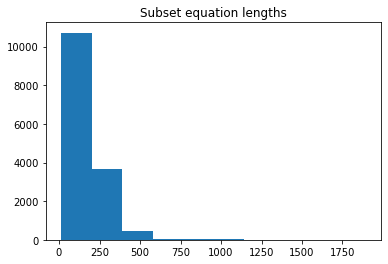

In [104]:
plt.hist([len(i) for i in subset])
plt.title('Subset equation lengths')
plt.show()

I also want to collect an even smaller subset of data so that I can test the pipeline for translating before committing to the big dataset

In [4]:
file=open('final_png_formulas.txt')
lines=file.readlines()
subset = random.sample(lines, 500)

with open('formulas_subset_small.txt', 'w', encoding='utf-8') as file:
    for line in subset:
        file.write(line)

## Estimating pricing

We'll have to make some assumtions to estimate this. Firstly, we'll be using gpt-3.5-turbo-instruct to do the translations which costs

`$`0.0015 per 1000 tokens read

`$`0.0020 per 1000 tokens generated

Let's assume that each token is about 5 characters. Additionally, let's set the max tokens that the model can generate to 400 so that full responses can be generated. Then the cost is hopefully around

In [108]:
print("Estimated cost: ", (sum([len(i) for i in subset]) / 5 / 1000 * .0015) + (400 * 15000 / 1000 * .002))

Estimated cost:  12.7719069


Let's cross our fingers and hope that's true!